# Install necessary libraries

In [ ]:
!pip3 install matplotlib pandas graphviz bs4 scikit-learn xgboost

# Import the libraries

In [63]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

# HTML Parsing

Build the id to conversation dictionary

In [4]:
data_path = "data/html/*.html"

id_to_conversation = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:

    file_id = os.path.basename(path).split(".")[0]

    with open(path, "r", encoding="latin1") as file:
        html = file.read()
        soup = BeautifulSoup(html, "html.parser")

        conversations = soup.find_all("div", attrs={"data-testid": re.compile(r"conversation-turn-[0-9]+")})

        conversation_texts = []
        for i, conversation in enumerate(conversations):
            conversation = conversation.find_all("div", attrs={"data-message-author-role": re.compile(r"[user|assistant]")})
            
            if len(conversation) > 0:
                role = conversation[0].get("data-message-author-role")
                conversation_texts.append(
                    {
                        "role" : role,
                        "text" : conversation[0].text
                    }
                )
        
        id_to_conversation[file_id] = conversation_texts

  0%|          | 0/127 [00:00<?, ?it/s]

100%|██████████| 127/127 [00:15<00:00,  8.20it/s]


Example conversation element (message)

In [5]:
pprint(id_to_conversation["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


# Prompt Matching

Build the id to user prompts dictionary, and collect all user prompts in a list

In [6]:
all_user_prompts = []

id_to_user_prompts = dict()

for id, conversation in id_to_conversation.items():
    user_prompts = []

    for message in conversation:
        if message["role"] == "user":
            all_user_prompts.append(message["text"])
            user_prompts.append(message["text"])
    
    id_to_user_prompts[id] = user_prompts

Faulty HTML files

In [18]:
faulty_ids = []

for id, user_prompts in id_to_user_prompts.items():
    if len(user_prompts) == 0:
        faulty_ids.append(id)

pprint(faulty_ids)

['139235c7-736c-4237-92f0-92e8c116832c',
 '668ad17e-0240-49f7-b5a7-d22e502554c6',
 'b0640e51-6879-40cb-a4f5-329f952ef99d',
 'da6b70d5-29f6-491a-ad46-037c77067128']


Homework questions list

In [7]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
#####################
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [8]:
# This list contains every prompt that students made
print(len(all_user_prompts))
print(all_user_prompts[0])

3544
Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. 



Vector representation of all words in the user prompts and questions

In [13]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(all_user_prompts + questions)

Build TF-IDF of the questions

In [15]:
questions_tf_idf = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_tf_idf.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Build TF-IDF of the user prompts, and put them in a id to user prompt TF-IDF dictionary

In [19]:
id_to_user_prompts_tf_idf = dict()
for id, user_prompts in id_to_user_prompts.items():
    if id in faulty_ids:
        # Skip the faulty ids
        continue
    user_prompts_tf_idf = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    id_to_user_prompts_tf_idf[id] = user_prompts_tf_idf

id_to_user_prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Build id to cosine similarities dictionary

In [31]:
id_to_cosine_similarities = dict()
for id, user_prompts_tf_idf in id_to_user_prompts_tf_idf.items():
    id_to_cosine_similarities[id] = pd.DataFrame(cosine_similarity(questions_tf_idf, user_prompts_tf_idf))

The values of this dictionary are the prompts of the user and their cosine similarity with the questions

In [34]:
id_to_cosine_similarities["089eb66d-4c3a-4f58-b98f-a3774a2efb34"]

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.058296,0.344182,0.152999,0.099802,0.074078,0.075629,0.093283,0.041655,0.038852,0.011217,...,0.000000,0.028546,0.013010,0.000000,0.0,0.000000,0.115756,0.040755,0.042855,0.034690
1,0.042217,0.575528,0.144428,0.101804,0.055783,0.057270,0.032213,0.024365,0.000000,0.000000,...,0.000000,0.000000,0.012138,0.000000,0.0,0.000000,0.033267,0.016194,0.025634,0.028188
2,0.014685,0.142663,0.782883,0.564132,0.163176,0.279906,0.113219,0.165363,0.052822,0.124913,...,0.000000,0.029310,0.019426,0.000000,0.0,0.000000,0.131680,0.060713,0.131547,0.057452
3,0.032012,0.070204,0.186448,0.075217,0.095748,0.049080,0.028651,0.067015,0.000000,0.000000,...,0.110646,0.063647,0.010796,0.000000,0.0,0.000000,0.069555,0.088949,0.077447,0.036186
4,0.034392,0.068048,0.122506,0.127868,0.061539,0.057405,0.047981,0.016774,0.061871,0.021462,...,0.000000,0.038973,0.024682,0.000000,0.0,0.000000,0.056014,0.267804,0.114717,0.054140
5,0.043754,0.063217,0.183422,0.146494,0.080187,0.095827,0.123328,0.046441,0.067172,0.058193,...,0.057095,0.021776,0.011333,0.039834,0.0,0.000000,0.553418,0.019758,0.060247,0.051688
6,0.038630,0.148123,0.237654,0.165833,0.092563,0.129901,0.078403,0.032026,0.000000,0.000000,...,0.000000,0.015676,0.015955,0.000000,0.0,0.000000,0.218495,0.056991,0.059679,0.097094
7,0.039444,0.099457,0.234103,0.140641,0.094564,0.130424,0.070768,0.036170,0.025894,0.008280,...,0.000000,0.012983,0.018019,0.000000,0.0,0.000000,0.080932,0.047050,0.071336,0.059621
8,0.000000,0.066991,0.191412,0.031838,0.058697,0.042023,0.041641,0.031496,0.000000,0.000000,...,0.000000,0.000000,0.015691,0.000000,0.0,0.252416,0.043004,0.028918,0.033136,0.017007


Build the id to question similarity dictionary

In [38]:
id_to_question_similarities = dict()
for id, cosine_similarities in id_to_cosine_similarities.items():
    # Across all prompts of this user, get the maximum cosine similarity for each question
    id_to_question_similarities[id] = id_to_cosine_similarities[id].max(axis=1).tolist()

id_to_question_similarities["089eb66d-4c3a-4f58-b98f-a3774a2efb34"]

[0.34418240100207875,
 0.5755275752159674,
 0.7828834061265147,
 0.6248330071633508,
 0.7248721614023372,
 0.8721707956757964,
 0.6847974466406526,
 0.9453053356136951,
 0.511769095790948]

Build the all question similarities dataframe. This dataframe rows contain the user id, and the maximum cosine similarity for each question across all prompts of this user

In [45]:
all_question_similarities = pd.DataFrame(id_to_question_similarities).T
all_question_similarities.reset_index(inplace=True)
all_question_similarities.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
all_question_similarities.rename(columns={"index" : "id"}, inplace=True)

all_question_similarities

,id,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


# Building the Model

Read the grades

In [52]:
grades = pd.read_csv("data/scores.csv", sep=",")
grades["id"] = grades["code"].apply(lambda x: x.strip())
grades = grades[["id", "grade"]]
grades.head()

,id,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


Grade distribution

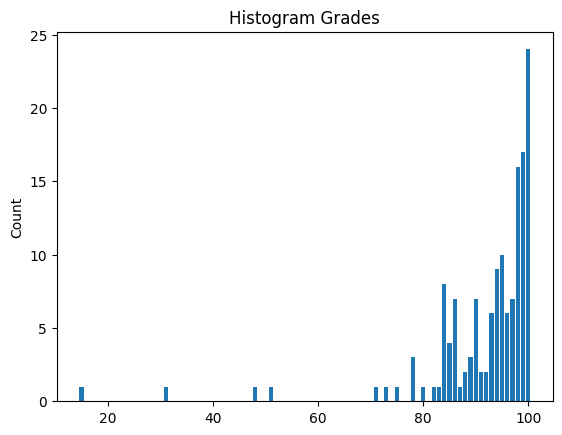

In [53]:
plt.title('Histogram Grades')
plt.hist(grades["grade"], rwidth=.8, bins=np.arange(min(grades["grade"]), max(grades["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

Build the df, merge with grades, and drop columns that have no grade

In [61]:
df = pd.DataFrame(all_question_similarities)
df = pd.merge(df, grades, on="id", how="left")
df.dropna(inplace=True)
df.drop_duplicates("id", inplace=True, keep="first")
df.head()

,id,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,100.0


Train the model

In [88]:
# Separate features (X) and target variable (y)
X = df.drop(['id', 'grade'], axis=1)
y = df['grade']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the XGBoost regression model
model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Optionally, you can inspect feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print('\nFeature Importances:')
print(feature_importances)

Mean Squared Error: 82.4583735055197

Feature Importances:
  Feature  Importance
0     Q_0    0.235756
1     Q_1    0.028363
2     Q_2    0.055457
3     Q_3    0.057930
4     Q_4    0.032493
5     Q_5    0.328439
6     Q_6    0.157763
7     Q_7    0.031231
8     Q_8    0.072568


Predict the grades

In [89]:
# Get unique user IDs
unique_user_ids = df['id'].unique()

# Predict grades for each user
for user_id in unique_user_ids:
    # Select the row corresponding to the user with the given ID
    user_data = df[df['id'] == user_id].drop(['id'], axis=1)

    # Extract the real grade
    real_grade = user_data['grade'].values[0]

    # Remove the 'grade' column for prediction
    user_data = user_data.drop(['grade'], axis=1)

    # Make the prediction
    predicted_grade = model.predict(user_data)

    # Print the results
    print(f'User ID: {user_id}')
    print(f'Real Grade: {real_grade}')
    print(f'Predicted Grade: {predicted_grade[0]}\n')

User ID: 0031c86e-81f4-4eef-9e0e-28037abf9883
Real Grade: 48.0
Predicted Grade: 80.97954559326172

User ID: 0225686d-b825-4cac-8691-3a3a5343df2b
Real Grade: 99.0
Predicted Grade: 98.99842071533203

User ID: 041f950b-c013-409a-a642-cffff60b9d4b
Real Grade: 90.0
Predicted Grade: 90.01436614990234

User ID: 04f91058-d0f8-4324-83b2-19c671f433dc
Real Grade: 97.0
Predicted Grade: 96.99897766113281

User ID: 089eb66d-4c3a-4f58-b98f-a3774a2efb34
Real Grade: 100.0
Predicted Grade: 97.08273315429688

User ID: 090d6217-5d69-4929-a342-19abab78324f
Real Grade: 84.0
Predicted Grade: 84.03948211669922

User ID: 0c95c563-f1e1-4a35-844c-2e8ccdd1b161
Real Grade: 96.0
Predicted Grade: 95.96345520019531

User ID: 0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc
Real Grade: 80.0
Predicted Grade: 79.99319458007812

User ID: 0e466794-f7f8-4cc2-b07e-070b13a0b5e1
Real Grade: 89.0
Predicted Grade: 88.99292755126953

User ID: 0f0c953a-a472-47c1-809b-9fc14dba9091
Real Grade: 83.0
Predicted Grade: 82.99581909179688

User ID: 

In [94]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Define the error range
error_range = 10

# Check how many predictions fall within the error range
correct_predictions = 0

for true_grade, predicted_grade in zip(y_test, predictions):
    if abs(true_grade - predicted_grade) <= error_range:
        correct_predictions += 1

# Calculate the percentage of correct predictions within the error range
percentage_correct = (correct_predictions / len(y_test)) * 100

# Print the results
print(f'Percentage of IDs with Predictions within ±{error_range} Points: {percentage_correct}%')

Percentage of IDs with Predictions within ±10 Points: 80.0%


In [91]:
# Prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train, y_train_pred))
print("MSE TEST:", mean_squared_error(y_test, y_test_pred))

print("R2 Train:", r2_score(y_train, y_train_pred))
print("R2 TEST:", r2_score(y_test, y_test_pred))

MSE Train: 0.0002506281086153677
MSE TEST: 82.4583735055197
R2 Train: 0.9999984663591741
R2 TEST: 0.26550632156671583
